In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import plotly.figure_factory as ff
# from plotnine import *
from pyecharts.charts import Map
from pyecharts import options
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_excel('../../data/爬取的数据.xlsx', sheet_name='非二手帆船')
df.head()

,Basics.Year,Basics.Make,Basics.Model,Basics.Class,Basics.Length,Basics.FuelType,Basics.HullMaterial,Basics.OfferedBy,Propulsion.EngineMake,Propulsion.TotalPower,...,Features.OutsideEquipment.WindGenerator,Features.InsideEquipment.Seakeeper,Features.InsideEquipment.AirCompressor,Features.InsideEquipment.ChemicalHead,Specifications.Miscellaneous.LiferaftCapacity,Features.Rigging.HydraulicWinch,Propulsion.RopeCutter,Specifications.Miscellaneous.DeadriseAtTransom,Features.AdditionalEquipment.LaunchingTrailer,Features.AdditionalEquipment.BeachingLegs
0,2023,Beneteau,Oceanis 46.1 - In Stock,Cruiser,46ft,Diesel,Fiberglass,"Cape Yachts at South Wharf - South Dartmouth, MA",yanmar,57hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,Jeanneau,Sun Odyssey 440,Cruiser,44ft,Diesel,Fiberglass,Marine Servicenter - San Diego,Yanmar,57hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,Jeanneau,Sun Odyssey 490,Cruiser,49ft,Diesel,Fiberglass,Marine Servicenter - Seattle,Yanmar,80hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,Jeanneau,60,Cruiser,60ft,Diesel,Fiberglass,Marine Servicenter - San Diego,Yanmar,150hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,Jeanneau,Yacht 65,Cruiser,65ft,Diesel,Fiberglass,Marine Servicenter - Seattle,Volvo,180hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info() # 有113个 object需要处理。  一共2188个条目。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Columns: 124 entries, Basics.Year to Features.AdditionalEquipment.BeachingLegs
dtypes: float64(10), int64(1), object(113)
memory usage: 2.1+ MB


In [4]:
df.columns # 太多了，分开处理 124
basics_columns = list(filter(lambda x:x.startswith('Basics'), df.columns))
propulsion_columns = list(filter(lambda x:x.startswith('Propulsion'), df.columns))
specification_columns = list(filter(lambda x:x.startswith('Specification'), df.columns))
feature_columns = list(filter(lambda x:x.startswith('Feature'), df.columns))

list(map(len, (basics_columns, propulsion_columns, specification_columns, feature_columns)))
price_column = ['Price']
df[price_column].describe()

,Price
count,1.163000e+03
mean,7.395047e+05
std,1.664770e+06
min,2.144000e+03
25%,1.412770e+05
50%,3.649000e+05
75%,6.918905e+05
max,2.450000e+07


## 针对 Basics进行处理

In [5]:
appropriate_types = {'定类':str, '定距':float, '定比':float, '定序':int}

In [6]:
should_be = ['定距', '定类', '定类', '定类', '定比', '定类', '定类', '定类', '定类', '定比']
should_be = list(map(lambda x: appropriate_types[x], should_be))
basics_columns, should_be

(['Basics.Year',
  'Basics.Make',
  'Basics.Model',
  'Basics.Class',
  'Basics.Length',
  'Basics.FuelType',
  'Basics.HullMaterial',
  'Basics.OfferedBy',
  'Basics.HullShape',
  'Basics.HullWarranty'],
 [float, str, str, str, float, str, str, str, str, float])

In [7]:
def len_tran(x):
    assert x.endswith('ft')
    return float(x[:-2])
df['Basics.Length'] = df['Basics.Length'].apply(len_tran).astype(float)

In [8]:
def war_tran(x):
    x = str(x)
    if x=='nan':
        return x
    num = x.split(' ')[0]
    return float(num)
df['Basics.HullWarranty'] = df['Basics.HullWarranty'].apply(war_tran).astype(float)

In [9]:
for col, typ in zip(basics_columns, should_be):
    df[col] = df[col].astype(typ)

In [10]:
df[basics_columns].dtypes

Basics.Year            float64
Basics.Make             object
Basics.Model            object
Basics.Class            object
Basics.Length          float64
Basics.FuelType         object
Basics.HullMaterial     object
Basics.OfferedBy        object
Basics.HullShape        object
Basics.HullWarranty    float64
dtype: object

In [11]:
df[basics_columns].isnull().sum()

Basics.Year               0
Basics.Make               0
Basics.Model              0
Basics.Class              0
Basics.Length             0
Basics.FuelType           0
Basics.HullMaterial       0
Basics.OfferedBy          0
Basics.HullShape          0
Basics.HullWarranty    1902
dtype: int64

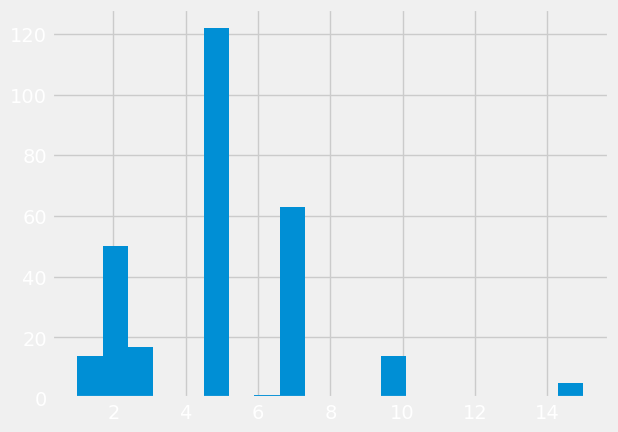

In [12]:
plt.hist(df['Basics.HullWarranty'].dropna(), bins=20)
plt.savefig('hull_warranty.png')

In [13]:
# from rpy2.robjects import r
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# # pandas2ri.activate()
# # r('install.packages("psych")')
# psych = importr('psych')

,Basics.HullWarranty,Price
Basics.HullWarranty,1.000000,-0.013242
Price,-0.013242,1.000000


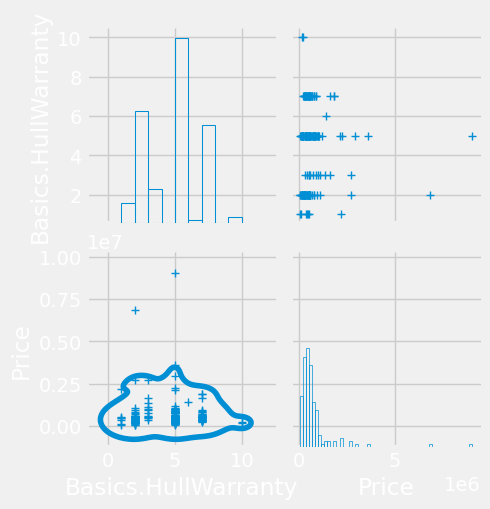

In [19]:
# psych.pairs_panels(df[['Basics.Year', 'Basics.Length', 'Basics.HullWarranty', 'Price']].dropna(), hist_col=price_column, scale=True)
# psych.pairs_panels(df[['Basics.HullWarranty','Price']].dropna(), hist_col=price_column, scale=True)
# sns.pairplot(df[['Basics.HullWarranty','Price']].dropna())
g = sns.pairplot(df[['Basics.HullWarranty','Price']].dropna(), 
                #  diag_kind="kde"
                 plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
                 )
g.map_lower(sns.kdeplot, levels=2)
plt.savefig('hull_warranty_price.png')

df[['Basics.HullWarranty','Price']].dropna().corr()

In [20]:
df[basics_columns].describe()

,Basics.Year,Basics.Length,Basics.HullWarranty
count,2188.000000,2188.000000,286.000000
mean,2017.692870,44.644671,5.024476
std,13.211266,18.140774,2.544225
min,1903.000000,6.730000,1.000000
25%,2022.000000,36.045000,3.000000
50%,2023.000000,42.250000,5.000000
75%,2023.000000,50.000000,7.000000
max,2026.000000,352.200000,15.000000


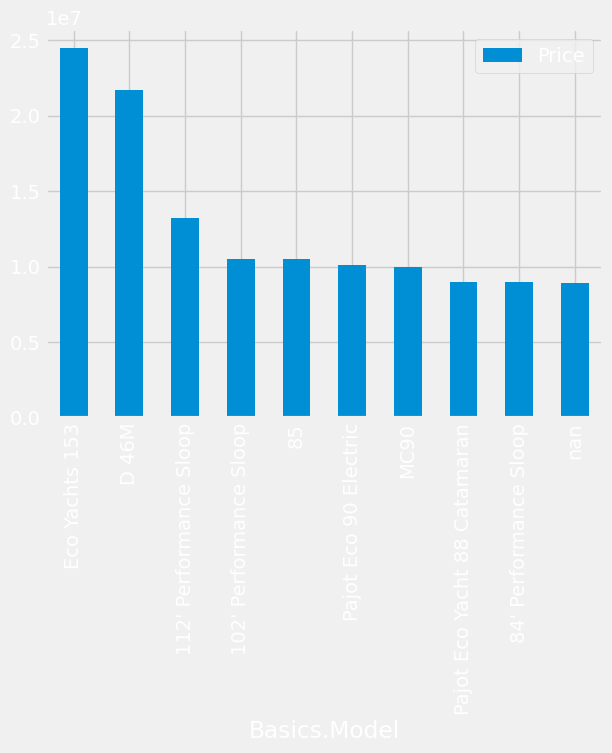

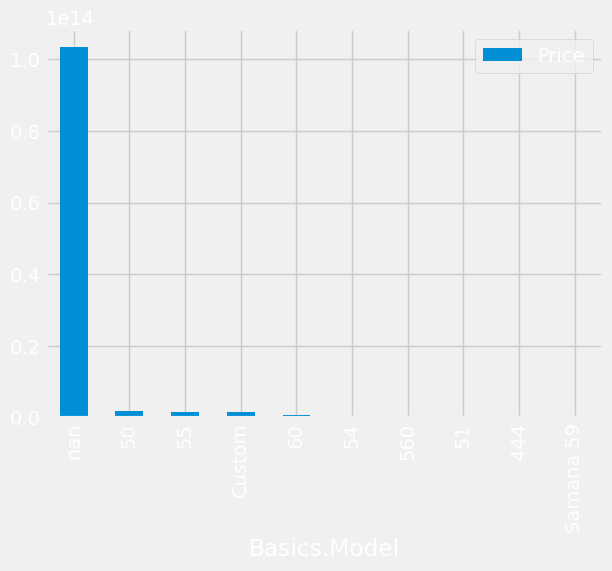

In [21]:
df.groupby(basics_columns[2])[price_column].mean().sort_values(price_column,ascending=False).head(10).plot.bar(stacked=True)
plt.savefig('price_basics_mean.png')
df.groupby(basics_columns[2])[price_column].var().sort_values(price_column,ascending=False).head(10).plot.bar(stacked=True)
plt.savefig('price_basics_var.png')

## 针对propulsion进行处理

In [22]:
should_be = ['定类', '定比', '定类', '定类', '定类', '定距', '定比', '定类', '定序', '定类', '定序', '定序']
should_be = list(map(lambda x: appropriate_types[x], should_be))
assert len(propulsion_columns) == len(should_be)
propulsion_columns, should_be

(['Propulsion.EngineMake',
  'Propulsion.TotalPower',
  'Propulsion.EngineType',
  'Propulsion.FuelType',
  'Propulsion.EngineModel',
  'Propulsion.EngineYear',
  'Propulsion.EngineHours',
  'Propulsion.DriveType',
  'Propulsion.PropellerType',
  'Propulsion.PropellerMaterial',
  'Propulsion.FoldingPropeller',
  'Propulsion.RopeCutter'],
 [str, float, str, str, str, float, float, str, int, str, int, int])

In [ ]:
def tran(x):
    if isinstance(x, float):
        return np.nan
    assert x.endswith('hp')
    return float(x[:-2])
df['Propulsion.TotalPower'] = df['Propulsion.TotalPower'].apply(tran).astype(float)
df['Propulsion.TotalPower'].head(2)

0    57.0
1    57.0
Name: Propulsion.TotalPower, dtype: float64

In [ ]:
df[propulsion_columns].head()

,Propulsion.EngineMake,Propulsion.TotalPower,Propulsion.EngineType,Propulsion.FuelType,Propulsion.EngineModel,Propulsion.EngineYear,Propulsion.EngineHours,Propulsion.DriveType,Propulsion.PropellerType,Propulsion.PropellerMaterial,Propulsion.FoldingPropeller,Propulsion.RopeCutter
0,yanmar,57.0,Inboard,Diesel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yanmar,57.0,Inboard,Diesel,4JH57CR,2022.0,2.0,Direct Drive,3 Blade,NaN,NaN,NaN
2,Yanmar,80.0,Inboard,Diesel,4JH80CR,2022.0,10.0,Sail Drive,3 Blade,NaN,NaN,NaN
3,Yanmar,150.0,Inboard,Diesel,LA 4LV150CR,2022.0,2.0,Direct Drive,3 Blade,Bronze,NaN,NaN
4,Volvo,180.0,Inboard,Diesel,D4,2022.0,NaN,Direct Drive,3 Blade,Bronze,✓,NaN


In [16]:
def tran(x):
    if isinstance(x, float):
        return np.nan
    if x.endswith(' blades'):
        return x[:-7]
    if 'folding' in x:
        return np.nan
    return np.nan
col = 'Propulsion.PropellerType'
df[col].head()
tran('2 blades')
df[col].map(tran)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2183   NaN
2184   NaN
2185   NaN
2186   NaN
2187   NaN
Name: Propulsion.PropellerType, Length: 2188, dtype: float64

In [ ]:
df[col] = df[col].map(tran)
# 定序类型的数据，应当使用中位数填充
# df[col] = df[col].fillna(df[col].median(), inplace=True) 
df[col].head(5)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Propulsion.PropellerType, dtype: float64

In [23]:
df[propulsion_columns].dtypes
df[propulsion_columns].isnull().count()

Propulsion.EngineMake           2188
Propulsion.TotalPower           2188
Propulsion.EngineType           2188
Propulsion.FuelType             2188
Propulsion.EngineModel          2188
Propulsion.EngineYear           2188
Propulsion.EngineHours          2188
Propulsion.DriveType            2188
Propulsion.PropellerType        2188
Propulsion.PropellerMaterial    2188
Propulsion.FoldingPropeller     2188
Propulsion.RopeCutter           2188
dtype: int64